In [1]:
pwd

'/Users/rayanemmanuelmendiola/Kresin_NanoClusterlab/Cl2Fe_Sims_0426 2'

In [2]:
import os
import pandas as pd
from tkinter.filedialog import askopenfilename
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf, erfinv # Modified code to include ionization factor (N^2/3)
from scipy.optimize import curve_fit
from math import exp,sqrt, log, sinh, cosh, floor
from pathlib import Path
import A_Deflection_Functions as funcs #File containing some helper functions

In [3]:
##Take PV fit to undeflected data
undeflected_data = np.loadtxt(askopenfilename(title="SELECT UNDEFLECTED DATA", initialfile="1_Fitted_Undeflected_Data"))

undeflected_left_boundary = undeflected_data[0,0] #domain of zero-field profile
undeflected_right_boundary = undeflected_data[-1,0]
undeflected_data_x_vals = undeflected_data[:,0]
undeflected_data_y_vals = undeflected_data[:,1]
undeflected_data_max = max(undeflected_data_y_vals)

##Take PV fit to deflected data, x-values will be used for simulation output
deflected_data =  np.loadtxt(askopenfilename(title="SELECT DEFLECTED DATA", initialfile= "2_Fitted_Deflected_Data"))
deflected_data_x_vals = deflected_data[:,0]
deflected_data_y_vals = deflected_data[:,1]
deflected_sim_right_bound = deflected_data_x_vals[-1]
deflected_sim_left_bound = deflected_data_x_vals[0]

simulated_deflection_data_x_vals = deflected_data_x_vals  # Instantiate array for sim output's xvals
      ## Temperature of the dopant in a given experiment

In [4]:
#### Simulation Parameters Here. Update/Check Each Run #####
rat = 0.9 #0.649336  #ratio of standard deviation to average droplet size
vx = 0.0 #velocity in the x-direction for a particular droplet; used by Droplet() & Deflection()
vz = 0.0 #velocity in the z-direction for a particular droplet; used by Deflection()

moleculeName = "Cl2Fe" ## Name of Molecule Used in Simulation
mDop = 126.75*1.66E-27 ## Multiply to change from amu to kg
pDop = 5.4             ## Magnetic moment of dopant (if known)
TDop = 638             ## Temperature of the dopant in a given experiment

v0 = 256          # From MCS data
number_of_iterations = int(1e4)   #Max number of trials per position in zero field data # JN quintupled
startAveN = 10000       # Reasonable first Guess

maxAveN = 14000   # Upper limit for loop
increment = 500   # Change in droplet size per loop
loopLimit = int((maxAveN - startAveN)/increment+1)

vibration_Boiloff = 1654

/var/folders/cb/h5zczmj9599_z1b87jrs5vnc0000gn/T/ipykernel_34403/451076882.py:53: RuntimeWarning: invalid value encountered in divide
  sizes = sizes / profHe.astype(float)


Starting Size: 10000
Average Surviving Droplet Size: 14991
Total Droplets Generated: 22795322
Survival Rate: 0.771 %
Time Elapsed:  0.99  Minutes
Starting Size: 10500
Average Surviving Droplet Size: 15763
Total Droplets Generated: 23340286
Survival Rate: 0.753 %
Time Elapsed:  1.98  Minutes
Starting Size: 11000
Average Surviving Droplet Size: 16462
Total Droplets Generated: 23649044
Survival Rate: 0.743 %
Time Elapsed:  3.0  Minutes
Starting Size: 11500
Average Surviving Droplet Size: 17092
Total Droplets Generated: 24119240
Survival Rate: 0.728 %
Time Elapsed:  4.04  Minutes
Starting Size: 12000
Average Surviving Droplet Size: 17839
Total Droplets Generated: 24556041
Survival Rate: 0.715 %
Time Elapsed:  5.09  Minutes
Starting Size: 12500
Average Surviving Droplet Size: 18543
Total Droplets Generated: 24916568
Survival Rate: 0.705 %
Time Elapsed:  6.15  Minutes
Starting Size: 13000
Average Surviving Droplet Size: 19173
Total Droplets Generated: 25352827
Survival Rate: 0.693 %
Time Ela

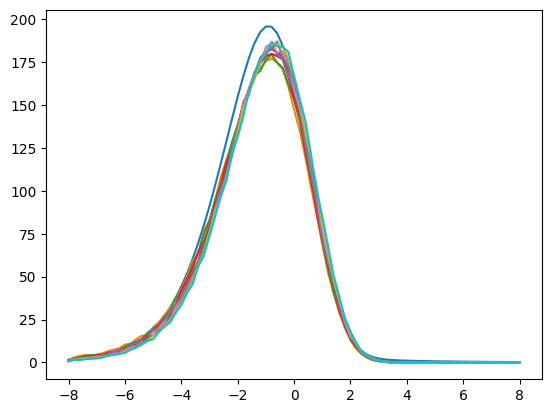

In [5]:
aveN = startAveN
plt.plot(deflected_data_x_vals,deflected_data_y_vals)
time_start = time.perf_counter()

for j in range(loopLimit):  

    totalDrops = 0
    totalSizes = 0
    totalSurvivingDrops = 0
    simulated_deflection_data_y_vals = np.zeros(len(deflected_data_x_vals),dtype=float) # Instantiate array for sim output's xvals
    profHe = np.zeros(len(deflected_data_x_vals)) #Output Droplet Profile
    sizes = np.zeros(len(deflected_data_x_vals)) #Average size of droplets as a function of position
    # This goes through each of the starting positions of imported file, need to switch with
    # the x values of the fitted profile. Right now, imported file is fitted data, but need to generalize


    mu = 0.5*log( (aveN*aveN) / (1.0 + rat*rat) )
    sig = sqrt( log(1.0 + rat*rat ) )  #sigma in log-normal distribution
    maxN = np.exp(sqrt(2.0)* sig * erfinv(2.0 * 0.9999 - 1.0) + mu) # Actually 99.9 th percentile droplet, which we'll call maximum
    ionNorm = maxN**(2.0/3.0)

    for i in range(len(undeflected_data_x_vals)):

          x0 = undeflected_data_x_vals[i] #Position at detector without deflection
          NIcrit = 0
          while NIcrit < int(np.around(number_of_iterations*undeflected_data_y_vals[i] / undeflected_data_max)):
                # While loop runs until there are enough droplets that survive the gaunlet
                # to match the intensity of the input profile assuming that the maximum of the profile
                # has number_of_iterations droplets that survive. So the wings have Y(x)*number_of_iterations/Max survived droplets 
                N = int(np.random.lognormal( mu , sig )) # Generate droplet of size N
                vz = np.random.normal(v0, 0.03*v0)
                totalDrops += 1
                if np.random.random() < N**(2.0/3.0)/ionNorm: # Dopant pick up as a function of cross section
                    N -= vibration_Boiloff
                    N = funcs.Boiloff(N,mDop,TDop,vz)
                    if np.random.random() < N**(2.0/3.0)/ionNorm: # Ionizes Droplet
                        if np.random.random() < exp(-0.06*(N**(1.0/3.0))): #CTP step
                            if N>0:
                                NIcrit += 1    #Keeps track of the total number of iterations
                                totalSurvivingDrops += 1
                                x = x0 - funcs.MagneticDeflection(N,pDop,mDop,v0)	#net deflection of a doped helium droplet
                                
    
                                
                                if (x< deflected_sim_right_bound) & (x>deflected_sim_left_bound): #If position in range

                                    nearest_x = funcs.find_nearest(deflected_data_x_vals, x )
                                    k = np.where(deflected_data_x_vals == nearest_x)[0][0]
                                    simulated_deflection_data_y_vals[k] += 1 # and molecule is ionized, then add to profile at k index corresponding to x position of deflected droplet
                                    profHe[k] += 1 #relative yield of dopants
                                    sizes[k] += N
                                    totalSizes += N
    sizes = sizes / profHe.astype(float)

    normed_simulated_deflection_data_y_vals = (undeflected_data_max / number_of_iterations) * simulated_deflection_data_y_vals
    output_combined = np.transpose([deflected_data_x_vals,normed_simulated_deflection_data_y_vals])
    sizes_combined = np.transpose([deflected_data_x_vals,sizes])

    np.savetxt("z_"+ str(aveN) +"_deflection.tsv", output_combined, delimiter="\t")
    np.savetxt("z_"+ str(aveN) +"_sizes.tsv", sizes_combined, delimiter="\t")

    print("Starting Size: "+ str(aveN))
    print("Average Surviving Droplet Size: "+ str(int(totalSizes/totalSurvivingDrops)))
    print("Total Droplets Generated: "+ str(totalDrops))
    print("Survival Rate: "+ str(round(totalSurvivingDrops/totalDrops*100, 3)) +" %")

    plt.plot(deflected_data_x_vals,normed_simulated_deflection_data_y_vals)

    aveN += increment
    
    print("Time Elapsed: ", round((time.perf_counter()-time_start)/60,2), " Minutes")
print("SIMULATION CONCLUDED")                                    